In [1]:
import pandas as pd
import gpboost as gpb
import shap
import matplotlib

/home/ecamo19/mambaforge/envs/spatial_random_forest_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.DataFrame(pd.read_csv("../data/cleaned_data/data_for_analysis.csv",  
                                header= 0))

# Remove first column
data = data.drop("Unnamed: 0", axis = 1)
data

,plot,x_wgs84,y_wgs84,AGB,n_species,uniqueness,redundancy,f_dis,sand,clay,...,mg,k,p,organic_matter,elev,slope_per,prec,preccv,temp,tempsd
0,F10P1,10.585146,-84.139067,56.037454,12,0.335369,0.664631,0.238918,35.21,43.19,...,1.83,0.22,2.0,4.39,133,11.096,4001,33,25.4,6.75
1,F10P2,10.588904,-84.142235,166.749103,19,0.324676,0.675324,0.230176,29.20,51.20,...,0.47,0.06,3.2,6.80,228,27.663,4301,32,25.0,6.60
2,F10P3,10.584973,-84.146899,160.211121,13,0.307718,0.692282,0.235566,39.21,33.19,...,3.78,0.28,1.8,4.60,187,17.156,4181,33,25.1,6.65
3,F10P4,10.586495,-84.147415,127.412325,15,0.324910,0.675090,0.221686,25.21,45.19,...,2.89,0.10,1.3,1.90,220,18.116,4088,33,25.2,6.65
4,F11P1,10.703767,-84.182987,172.433217,20,0.320853,0.679147,0.223718,23.21,63.59,...,0.30,0.05,3.0,6.60,40,16.930,3658,39,25.8,6.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,F8P1,10.540179,-84.169864,110.386006,13,0.373003,0.626997,0.259112,8.02,78.38,...,0.20,0.04,1.7,3.40,80,1.961,3545,34,25.9,6.79
123,F8P2,10.542715,-84.169786,69.695665,9,0.357282,0.642718,0.238927,12.02,74.39,...,0.24,0.04,1.5,3.37,70,0.000,3545,34,25.9,6.79
124,F9P1,10.535147,-84.293634,77.033760,9,0.344945,0.655055,0.237811,16.01,70.39,...,0.49,0.14,1.9,4.53,70,0.000,3168,41,25.9,7.48
125,F9P2,10.531583,-84.291950,126.107512,12,0.354232,0.645768,0.247024,10.01,76.39,...,0.60,0.07,2.0,4.48,70,0.000,3168,41,25.9,7.48


In [3]:
# Define response variables

# Number of species per plot
y_n_species = data["n_species"]

# Plot aboveground biomass
y_agb = data[["AGB"]]

# Plot functional redundancy
y_redundancy = data[["redundancy"]]

# Plot functional diversity
y_fdis = data[["f_dis"]]


In [57]:
# Correlations between predictors
cormat = data[["redundancy", "AGB", "f_dis", "n_species"]].corr()
round(cormat,2)

,redundancy,AGB,f_dis,n_species
redundancy,1.00,0.03,-0.97,0.09
AGB,0.03,1.00,0.05,0.52
f_dis,-0.97,0.05,1.00,0.05
n_species,0.09,0.52,0.05,1.00


In [4]:
# Define coordinates
coords = data[['x_wgs84','y_wgs84']]

In [6]:
# Define predictors
predictors = data.iloc[0:, 8:]

predictors

,sand,clay,p_h,acidity,ca,mg,k,p,organic_matter,elev,slope_per,prec,preccv,temp,tempsd
0,35.21,43.19,4.7,7.26,4.47,1.83,0.22,2.0,4.39,133,11.096,4001,33,25.4,6.75
1,29.20,51.20,4.4,3.40,0.62,0.47,0.06,3.2,6.80,228,27.663,4301,32,25.0,6.60
2,39.21,33.19,5.7,0.22,11.02,3.78,0.28,1.8,4.60,187,17.156,4181,33,25.1,6.65
3,25.21,45.19,5.9,1.57,6.81,2.89,0.10,1.3,1.90,220,18.116,4088,33,25.2,6.65
4,23.21,63.59,4.5,2.54,0.15,0.30,0.05,3.0,6.60,40,16.930,3658,39,25.8,6.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,8.02,78.38,4.6,2.29,0.40,0.20,0.04,1.7,3.40,80,1.961,3545,34,25.9,6.79
123,12.02,74.39,4.5,2.64,0.38,0.24,0.04,1.5,3.37,70,0.000,3545,34,25.9,6.79
124,16.01,70.39,4.6,2.31,1.46,0.49,0.14,1.9,4.53,70,0.000,3168,41,25.9,7.48
125,10.01,76.39,4.6,2.72,1.39,0.60,0.07,2.0,4.48,70,0.000,3168,41,25.9,7.48


# Tree-Boosting for Spatial Data
[Tutorial](https://towardsdatascience.com/tree-boosting-for-spatial-data-789145d6d97d)

# Work on tuning parameters!

## Model specifications

In [7]:
# Define model
# Find the shape parameter using gpgp
gp_model = gpb.GPModel(gp_coords = coords, 
                        cov_function = "matern", 
                        cov_fct_shape = 0.5)

In [26]:
params = { 'objective': 'regression_l2', 
            'learning_rate': 0.01,
            'max_depth': 3, 
            'min_data_in_leaf': 10, 
            'num_leaves': 2**10, 
            'verbose': 0 }
params

{'objective': 'regression_l2',
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_data_in_leaf': 10,
 'num_leaves': 1024,
 'verbose': 0}

### Aboveground Biomass

In [27]:
data_abg = gpb.Dataset(predictors, y_agb)

In [28]:
# Training
bst_agb = gpb.train(params = params, 
                train_set = data_abg,
                gp_model = gp_model, 
                num_boost_round = 247)

In [29]:
# Estimated covariance parameters
gp_model.summary()

Covariance parameters (random effects):
               Param.
Error_term  3079.1025
GP_var       649.0900
GP_range       0.0716


In [31]:
# Make predictions: latent variables and response variable
pred = bst_agb.predict(data = predictors, 
                    gp_coords_pred = coords,  
                   predict_var = True, 
                   pred_latent = True)

In [32]:
pred_resp = bst_agb.predict(data = predictors, 
                        gp_coords_pred = coords, 
                        predict_var = False, 
                        pred_latent = False)

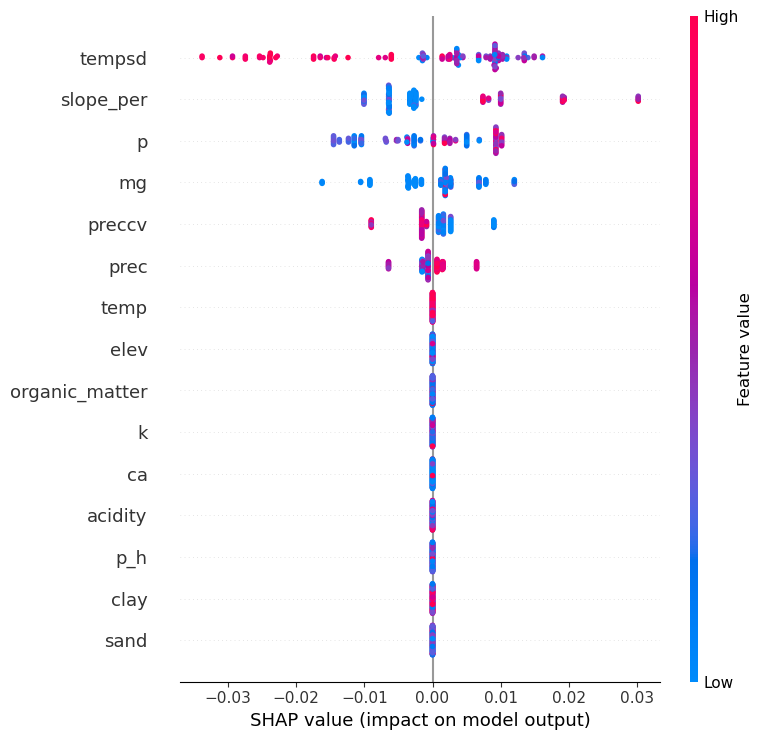

In [33]:
shap_values = shap.TreeExplainer(bst_agb,).shap_values(predictors,)
shap.summary_plot(shap_values, predictors)

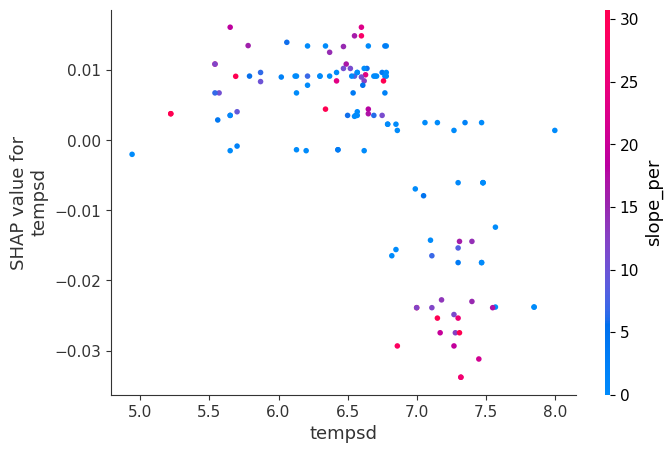

In [64]:
shap.dependence_plot("tempsd", shap_values, predictors)

### Functinal Redundancy 

In [36]:
data_redundancy = gpb.Dataset(predictors, y_redundancy)

In [37]:
# Training
bst_redundancy = gpb.train(params = params, 
                train_set = data_redundancy,
                gp_model = gp_model, 
                num_boost_round = 247)

In [39]:
pred_redundancy = bst_redundancy.predict(data = predictors, 
                                        gp_coords_pred = coords,  
                                        predict_var = True, 
                                        pred_latent = True)

In [40]:
pred_resp_redundancy = bst_redundancy.predict(data = predictors, 
                        gp_coords_pred = coords, 
                        predict_var = False, 
                        pred_latent = False)

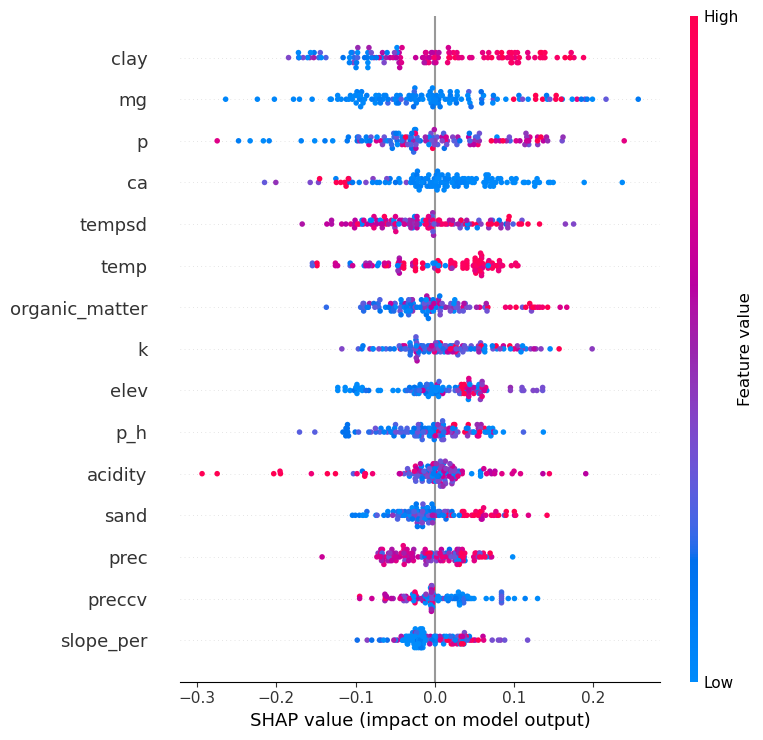

In [50]:
shap_values_redundancy = shap.TreeExplainer(bst_redundancy,).shap_values(predictors,)
shap.summary_plot(shap_values_redundancy, predictors)

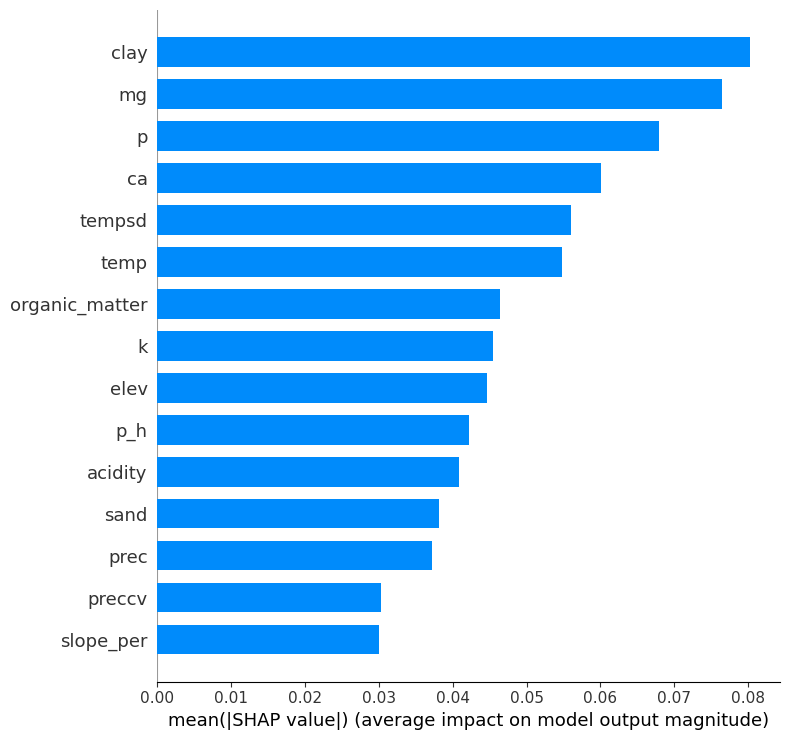

In [65]:
shap.summary_plot(shap_values_redundancy, predictors, plot_type = "bar")
#shap.plots.bar(shap_values_redundancy)

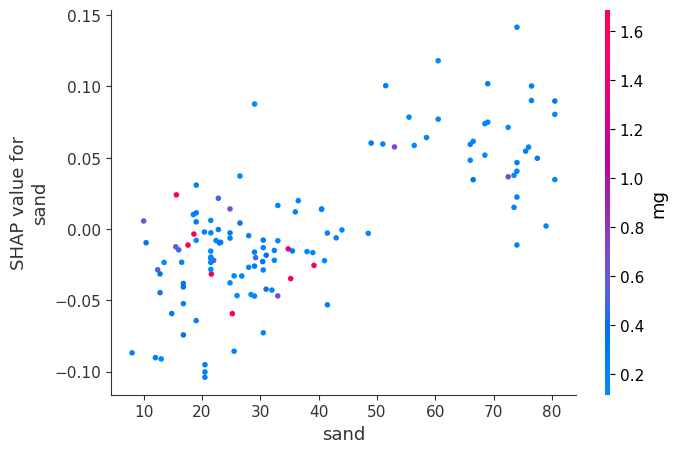

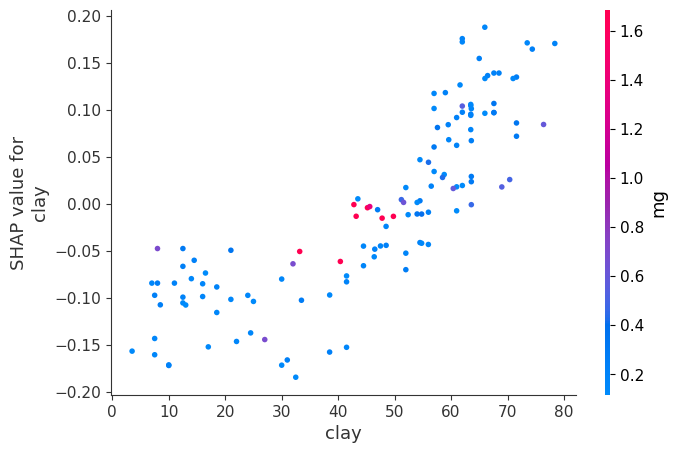

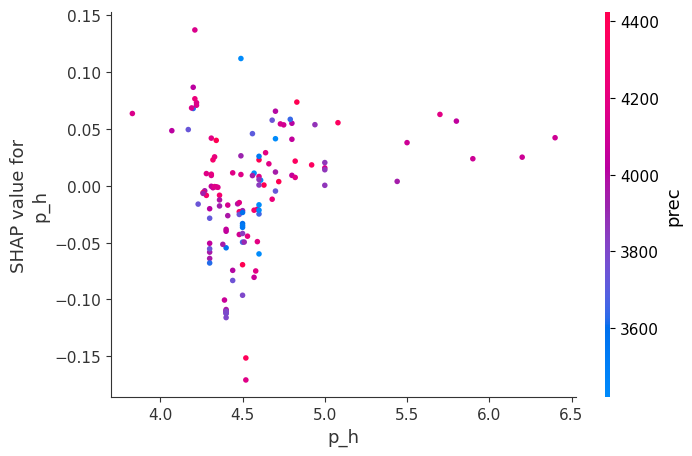

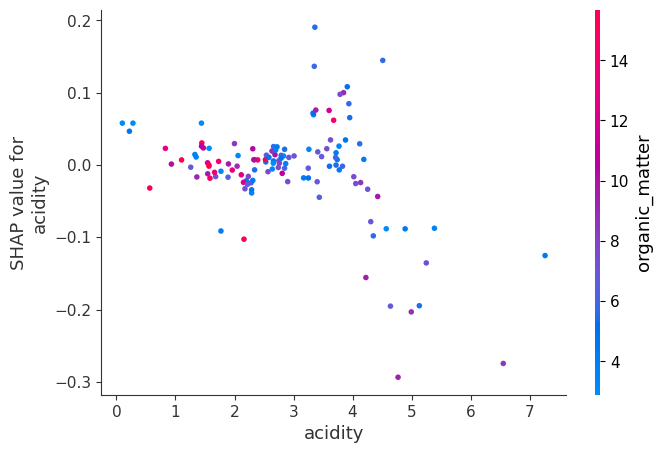

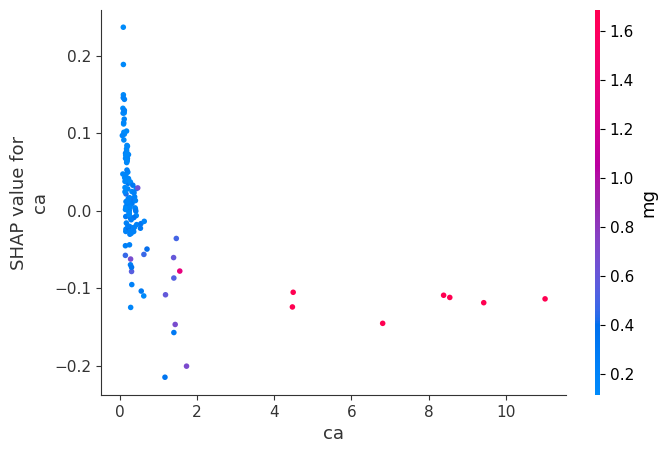

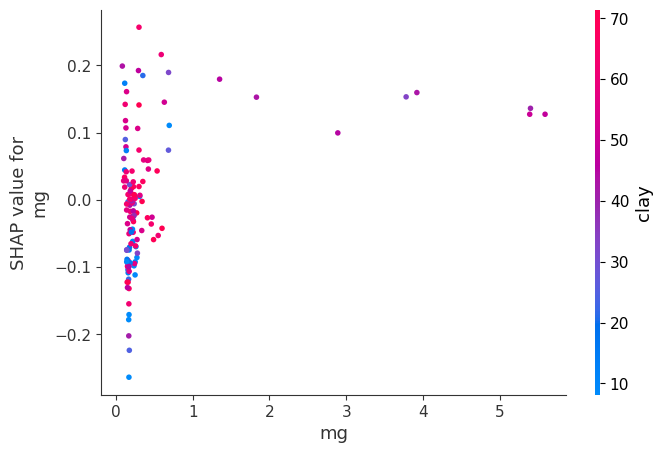

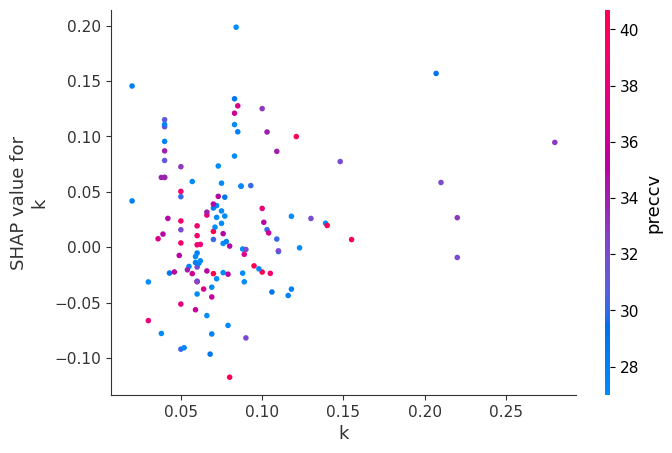

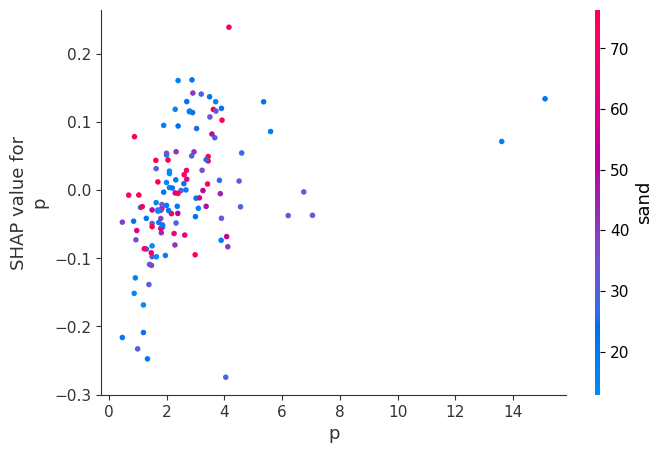

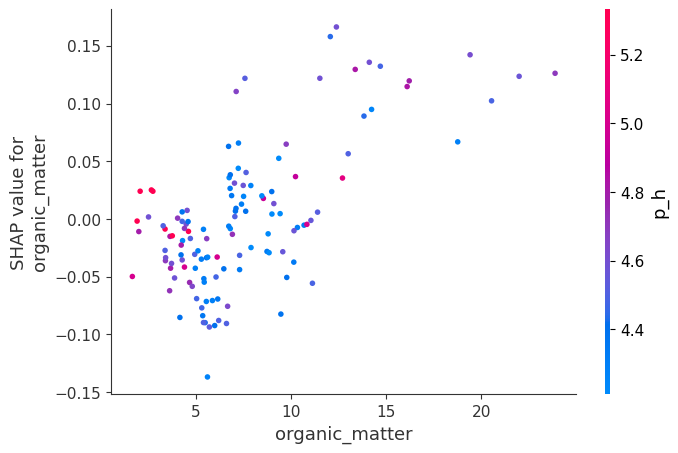

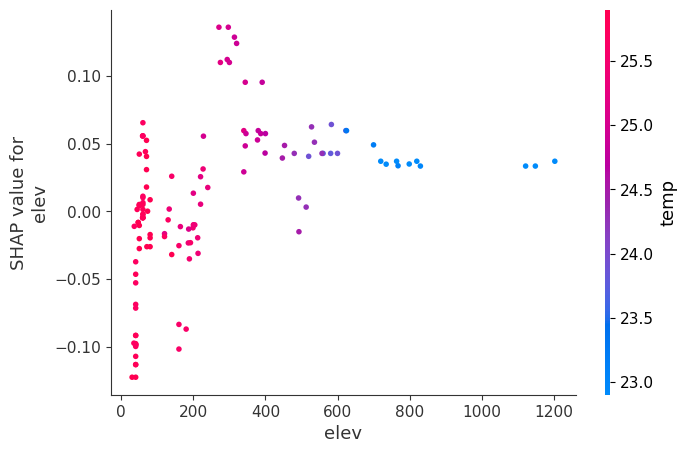

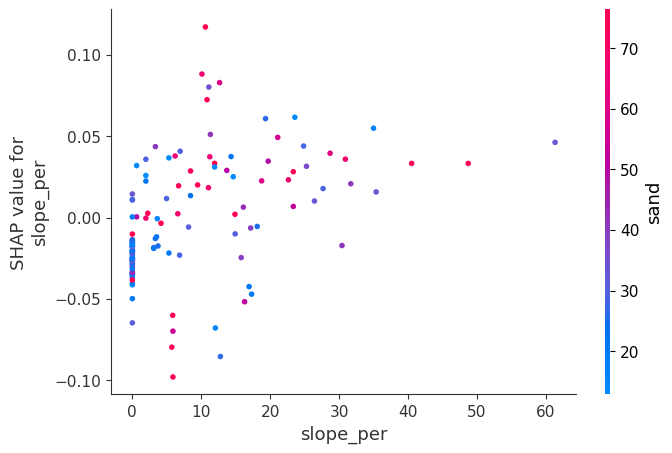

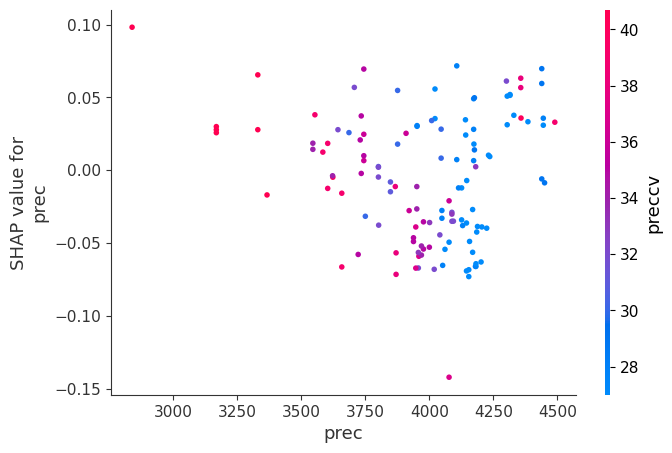

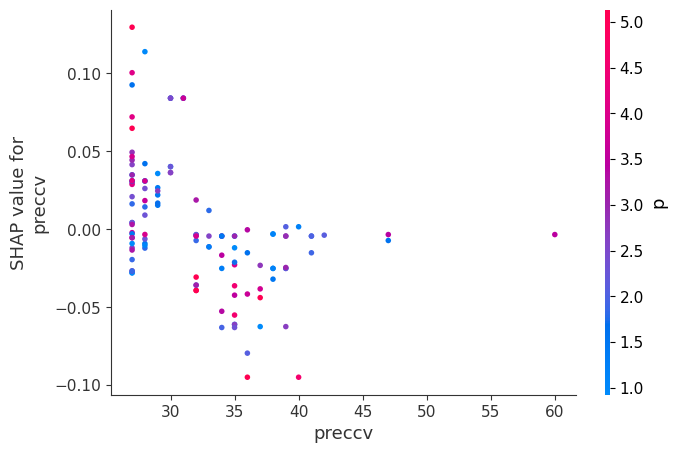

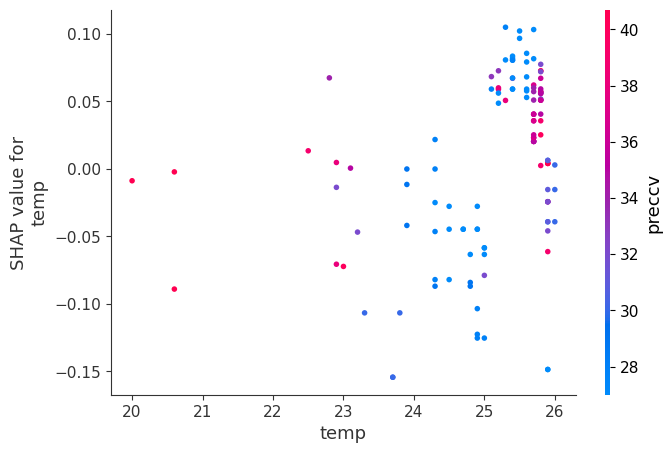

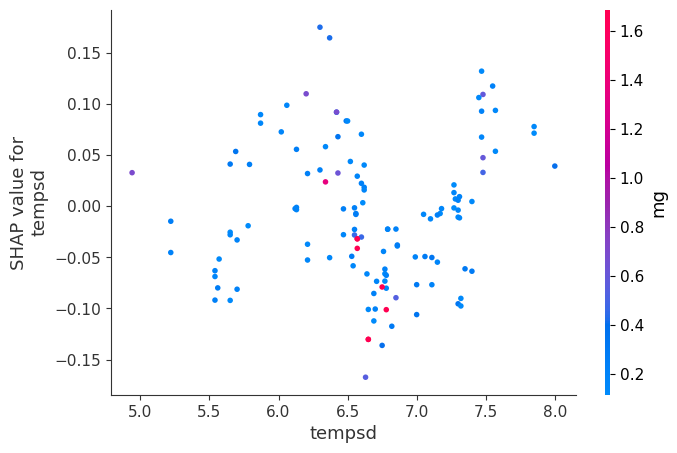

In [47]:
for name in predictors.columns:
    shap.dependence_plot(name, shap_values_redundancy, 
                            predictors, 
                            display_features = predictors)